In [7]:
# setup the matplotlib graphics library and configure it to show 
# figures inline in the notebook
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

# Loss Functions

## Glossary
- MAE - Mean Absolute Error
- MAP - maximum a posterior estimation
- MLE - maximum likelihood estimation. From Bayes’ perspective, MLE is a special case of MAP that assumes uniform prior distribution of the parameters. Maximizing the likelihood is asymptotically equivalent to minimizing KLD, thus finding  that defines the probability distribution that has a minimal distance (or divergence) to real probability from which data was generated.
- MSE - mean square error
- KLD - Kullback-Leibler Divergence

In this article, we will focus on the selection of loss functions for regression and classification problems. First, we justify minimizing the mean square error (MSE) as a loss function for linear regression. We will proceed from the statement of the regression as a task with an infinite number of outcomes, thereby naturally assuming that the loss function, in this case, will be continuous. In contrast, the problem of classification has a discrete number of outcomes, and its loss function does not have the same nature as for regression. We will introduce a metric on the distribution space approximating the classification values and show that although the introduced value may not have all the properties of the metric, it can nevertheless serve to determine the “distance” between distributions, that is, it can be successfully used as a loss function. The considered quantity called cross-entropy, and it is widely used in commercial libraries (TensorFlow, PyTorch) when constructing classification models.

## 1. Maximum likelihood estimation (MLE) and KL Divergence {#KLD}
There are many ways to introduce a metric on a distribution space. Some metrics were borrowed from functional analysis, while others, due to their special properties, were introduced for special cases. Such cases include pre-metrics that satisfy only part of the axiomatics of metrics, however, they are often used to specify the topology of the distribution space, and to some extent play the role of the distance on it. Such is the pre-metric that is known from information theory: the Kullback-Leibler divergence. For discrete distributions, it is defined as
$$D_{KL}(P||Q)  =\sum_{x \in X} P(x) \log(\frac{P(x)}{Q(x)})$$

And for continuous distributions:

$$D_{KL}(P||Q)=\int_{\infty}^{-\infty} p(x) \log(\frac{p(x)}{q(x)}) dx$$
This divergence is not symmetrical and does not satisfy the triangle inequality:
$$D_{KL}(P||Q) \neq D_{KL} (Q||P)$$

The only fact that the Kullback-Leibler divergence is related to the metric is that it is not negative and is equal to zero only for $P=Q$ almost everywhere.

In order to explain the meaning of the introduced quantity, let us step back and try to formalize the intuitive idea that the amount of information that an event carries is the greater the less this event, i.e. the less likely the event, the more informative it is.

This is expressed well by the function on the graph below:

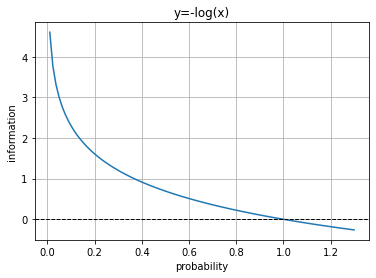

In [8]:
x = np.linspace(0.01, 1.3, 100)
plt.title('y=-log(x)')
plt.xlabel('probability')
plt.ylabel('information')
plt.plot(x, -np.log(x))

plt.axhline(y=0, color='black', linestyle='--', lw=1)

plt.grid()

plt.show()


The probability of the event is plotted on the  axis $x$, its “amount of information" on the axis. You can notice that this function on the segment $[0\le x \le 1]$ fits perfectly to the given intuitive expression. 

1. It takes 0 on a value of 1 - the maximum allowable probability value, i.e. the information contained in the event that is certain to happen (with probability 1) is zero.
2. The lower the probability of an event, the greater its information: $\lim_{x \to +0}=\infty$
3. $ \forall x \in [0 \ge x \ge 1]: I(x) \ge 0 $

The considered value was introduced by C. Shannon in the epoch-making work [^4], and received the name of the event’s *self-information*:
$$I(x)=-log p(x)$$
where the negative sign ensures that information is positive or zero.
The choice of basis for the logarithm is arbitrary, but by the convention in information theory it is used to the base of 2.

It is readily extended from a single event to the entire (discrete) distribution:
$$H(X)=-\sum_{i=1}^m p(x) \times \log p(x)$$

In this case, it is called the *entropy (information entropy)* of a random variable and it is effectively the expectation of the self-information with respect to the distribution .

Considering entropy as a measure of chaos or distribution uncertainty, we now note its features for known distributions.
1. In general, a non-uniform distribution has less entropy than a uniform
2. The uniform distribution has the largest entropy of all possible:
$$H(P) = - \sum_{i=1}^n \frac{1}{n} \log \frac{1}{n} = - \frac{n}{n} ( - \log n) = \log n$$
3. Distributions $p(x_i) $ that are sharply peaked around a few values will have a relatively low entropy, whereas those that are spread more evenly across many values will have higher entropy.
4. The entropy of Gaussian:
$$H(P)=\ln(\sigma \sqrt{2 \pi e })$$
independent of the mean. (This is [calculated](http://cito-web.yspu.org/link1/metod/theory/node30.html) using the discrete Abel transform or integration by parts for the continuous case) and we can see again that the entropy increases as the distribution becomes broader, i.e., as $\sigma$ increases.

5. The Laplace distribution (double exponential), which is often used as the limit distribution in schemes of summing a random number of random variables, has entropy:
$H(X) = - \int_{-\infty}^{+\infty} \frac{2}{\lambda} e^{- \lambda |x-a| } \log \frac{2}{\lambda} e^{- \lambda |x-a|} dx= \log \frac{2}{\lambda}$ that also independent of the mean. ([Calculated](http://cito-web.yspu.org/link1/metod/theory/node30.html) by the same way)
6. Finally, the entropy of the binomial distribution:
$$H(X)=\sum_{m=0}^{n}$$

Generally speaking, the informational entropy is deeply related to physical entropy. Nature seems to us not to be orderly, i.e. any manifestations of the organized structure of physical space can be considered as manifestations of a temporary anomaly. The uniform distribution of properties with its maximum entropy is, in fact, the essence of the second law of thermodynamics.

When comparing the two distributions, it makes sense to consider the cross-entropy, which is defined as:
$$H(P,Q)=-\sum_{x \in X} p(x_i) \log q(x_i)$$

There are no problems with generalizing the introduced values to continuous distributions. In this case, the quantity under consideration is called differential entropy and is derived as the first term of the asymptotic expansion of entropy [^5].

Here, we are primarily interested in the discrete case, so let us return to the Kullback-Leibler divergence and write out its discrete form in more detail:
$$D_{KL}(P||Q)  =\sum_{x \in X} P(x) \log(\frac{P(x)}{Q(x)}) =-\sum_{x \in X} p(x) \log q(x) + \sum_{x \in X} p(x) \log p(x) = H(P,Q) - H(P)$$
where $H(P, Q)$ - cross entropy between $P$ and $Q$, $H(P)$ - entropy of $P$.

For now, as an important milestone, we have:
$$D_{KL}(P||Q) = H(P,Q) - H(P)$$

Kullback-Leibler divergence also applies to continuous distributions. For example, we find a Kullback-Leibler divergence between two normal distributions $p(x) = \mathbb{N}(x| \mu_1, \sigma_1)$ and $q(x) = \mathbb{N}(x| \mu_2, \sigma_2)$ (PRML [2], Bishop ex. 1.30, p.64)

$$D_{KL}(p||q)=-\int p(x) \log q(x) dx + \int p(x) \log p(x) dx = $$
$$= \frac{1}{2} \log (2 \pi \sigma_2^2) + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2 \sigma_2^2} - \frac{1}{2}(1+\log 2 \pi \sigma_1^2) =$$
$$= \log \frac{\sigma_2}{\sigma_1} + \frac{\sigma_1^2 + (\mu_1 - \mu_2)^2}{2 \sigma_2^2} - \frac{1}{2}$$

The last expression gives 0 when $\mu_1=\mu_2$ and $\sigma_1=\sigma_2$.

For further discussion, recall the definition of the likelihood function. It is a function of the distribution parameter $f_x(x|\theta): \Theta \to R$ and defined as:
$$\Theta_{ML}=\prod_{i=1}^{\infty} p(x_i | \theta)$$

Here $p(x_i)$ can be chosen either as a CDF (Cumulative Distribution Function, **or as a PDF (Probability DensityFunction)**

Its argmax will not change during logarithm, so:
$$\Theta_{ML}=\arg \max_{\Theta} \prod_{i=1}^m p_{model}(x_i, \Theta)=\arg \max_{\Theta} \sum_{i\div 1}^m \log p_{model}(x_i, \Theta)$$

Argmax will not change also when divided by $m$, therefore:
$$ \Theta_{ML}=arg \max_{\Theta}\mathbb{E} \log p_{model}(x, \Theta) $$

Now recalling (1) we can write:
$$D_{KL}(P_{data}||P_{model})= \mathbb{E}_{data}[\log p_{data}(x) - \log p_{model}(x)]$$

but since the left term of the resulting expression does not depend on $P_{model}$ in minimizing the divergence, we actually only have to minimize
$$- \mathbb{E} [\log p_{model}(x)]$$

which coincides with (4). Thus, **maximizing the likelihood is equivalent to minimising the Kullback-Leibler divergence.**

## 2. MLE and linear regression
### 2.1 Linear regression with normal noise

If we consider linear regression in the form:
$$Y = w^TX + \epsilon$$
where $\epsilon$ - normally distributed random variable (noise) with expected value $\mu$ and dispersion $\sigma$, i.e. $\epsilon \sim N(\mu, \sigma^2)$,  then the values of $Y$ are also distributed normally with a probability density corresponding to a multidimensional normal distribution. The likelihood function of such a distribution, in which the probability density is used, takes the form

$$L(\Theta) = \prod_{i=1}^{m} p(y_i|x_i;w,\sigma) = \prod_{i=1}^{m} \frac{1}{\sqrt{2 \pi \sigma^2}} \times e^{-\frac{(y_i-w_i x_i)^2}{2\sigma^2}}$$

where $\Theta$ - vector $(w, \sigma)$.

After logarithm (because $\log (\prod_{i=1}^m a_i b_i) = \sum_{i=1}^m \log a_i b_i$ ) this gives:
$$\ln \prod_{i=1}^m p(y_i|x_i;w,\sigma) = \sum_{i=1}^m \ln p(y_i|x_i;w,\sigma) = \sum_{i=1}^m \ln [ \frac{1}{\sqrt{2 \pi \sigma^2}} e^{-\frac{1}{2} (\frac{y_i-\hat y_i}{\sigma})^2}]=$$
$$=\sum_{i=1}^m [ \ln(2\pi \sigma^2)^{-\frac{1}{2}} + \ln e^{-\frac{1}{2} (\frac{y_i-\hat y_i}{\sigma})^2}] = \sum_{i=1}^m [ -\frac{1}{2} \ln( 2 \pi) - \log \sigma - \frac{1}{2\sigma^2} (y_i - \hat y_i)^2]=$$
$$= - \frac{m}{2} \log (2 \pi) -m \ln \sigma - \frac{1}{2 \sigma^2} \sum_{i=1}^{m} (y_i - \hat y_i)^2$$
where $\hat y_i$ -  model calculation result for an element $x_i$ and $m$ - number of sample items.
But since the first two members of the right-hand side of the last expression are independent of the model parameters ($\sigma$ constant) then we can write:
$$\Theta_{ML} = \arg \max_{\Theta} - \sum_{i=1}^m \frac{1}{2} |y_i- \hat y_i|^2 = \min \sum_{i=1}^{m} |y_i - \hat y|^2$$

Comparing this expression with the definition of the mean square error:
$$ MSE = \frac{1}{m} \sum_{i=1}^{m} | \hat y_i - y_i |^2 $$

you can easily see that the likelihood maximization relative to the desired vector $\Theta$ s, in fact, the minimization of the mean square error for the same parameters. 
Which actually shows that MSE is the optimal function of the linear regression error.

### 2.2 Linear regression with Laplace noise

If the noise in linear regression has a Laplace distribution:
$$p(\epsilon)= \frac{\alpha}{2} e^{-\alpha |\epsilon - \beta|}$$

with zero mean ($\beta=0$) then the logarithmic maximum likelihood estimation gives:
$$Q_{ML} = \arg \min_q \frac{1}{m} \sum_{i=1}^m |a(x_i) - y_i|$$
i.e.. Mean Absolute Error (MAE).

### 2.3 Recapitulation
Thus, linear regression can be defined without assuming a normal noise distribution. Its parameters can be calculated by MSE, however, this method will be optimal only in the case of a normal distribution.

## 3. Bayesian inference and likelihood
Consider the same expression for linear regression (5)
Y = w^TX + \epsilon
but this time  $\epsilon$ will not be random and alternatively we will consider the vector $w$ as a random variable distributed with some a-priori known probability density $p(w)$.
Then by definition of conditional probability:
$$P(X|Y)(w) \equiv \frac{\tilde P(X, Y)}{P(Y)}$$
where $\tilde P(X, Y)$ is a joint probability of distributions $X$ and $Y$.
Due to the probability rule chain, the joint probability is expressed through the conditional as:
$$\tilde P(X, Y) = P(X) P(Y|X)$$
On other hand, because all the variables are independent we have $P(Y|X) = L_{Y,X}(w)$ and the finally:
$$P(X|Y)(w) = \frac{P(X)  L_{Y,X}(w)}{P(Y)}$$
where $L_{Y,X}(w)$ is the likelihood of distribution $Y$ from the observed values of a random variable $X$ depending on the parameter $w$. This is the same likelihood function that we defined in (3)!

The left side of the last equality is called a posteriori probability.
The denominator in (7) is independent of $w$ and serves as a normalization constant, which ensures that the left-side of the equation is valid probability density and integrates to one, so:
$$P(Y)=\int L_{Z,Y}(w) P(X) dx = 0$$
The product of the probabilities in the numerator of the Bayes formula must be produced for each element of the sample, which is practically impossible for real data sets containing up to hundreds of thousands of elements.
However, for many practical cases, knowledge of [conjugate prior](https://en.wikipedia.org/wiki/Conjugate_prior) allows replacing the time-consuming integration operations with simple algebraic manipulations of distribution parameters.
The development of sampling methods, such as Markov chain Monte-Carlo opened the door to the practical use of Bayesian methods. Monte-Carlo methods are very flexible, but computationally intensive and have mainly used for small-scale problems.
On other hand, there are highly effective deterministic approximation schemes, such a variational Bayes and expectation propagation that allowed Bayesian techniques to be used in large-scale applications.


## Literature
- [^1] Kullback S. (1959). Information theory and statistics. Dover Publications.
- [^2] Bishop C. M. (2006). Pattern Recognition and Machine Learning. Springer.
- [^3] Goodfellow I,. Bengio Y., Courville A. (2016) Deep Learning. MIT Press.
- [^4] Shannon C. E. A mathematical Theory of Communication. 
- [^5] Колмогоров А. Н. Теория информации и теория алгоритмов.

